In [39]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.backend import square, mean

look_back = 4 * 36
num_epochs = 7
seq_len = 4 * 2
batch_size=256
loss="mse"
ewm=8
units=256

In [40]:
def getDataset():
    url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
    df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
    df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df.set_axis(df['date'], inplace=True)
    df.drop(columns=["date"], inplace=True)
    df["Close"]= df["close"] # compatibility
    df.drop(columns=['close'], inplace=True)
    return df

In [41]:
# def getDataset():
#     url = "./datasets/eurusd-m15-2018/EURUSD.csv"
#     df = pd.read_csv(url)
#     df.drop("Volume", 1, inplace=True)
#     df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
#     df['Date'] = pd.to_datetime(df['Date'])
#     df.set_index("Date", inplace=True)
#     # df.drop("Date", 1, inplace=True)
#     df.drop("Timestamp", 1, inplace=True)
#     df.drop("Open", 1, inplace=True)
#     df.drop("High", 1, inplace=True)
#     df.drop("Low", 1, inplace=True)

#     return df

In [42]:
df = getDataset()
dflen=len(df)
df=df[:int(dflen/8)]
df.head()

,Close
date,
2018-01-01 17:00:00,1.20100
2018-01-01 17:01:00,1.20030
2018-01-01 17:02:00,1.20043
2018-01-01 17:03:00,1.20046
2018-01-01 17:04:00,1.20048


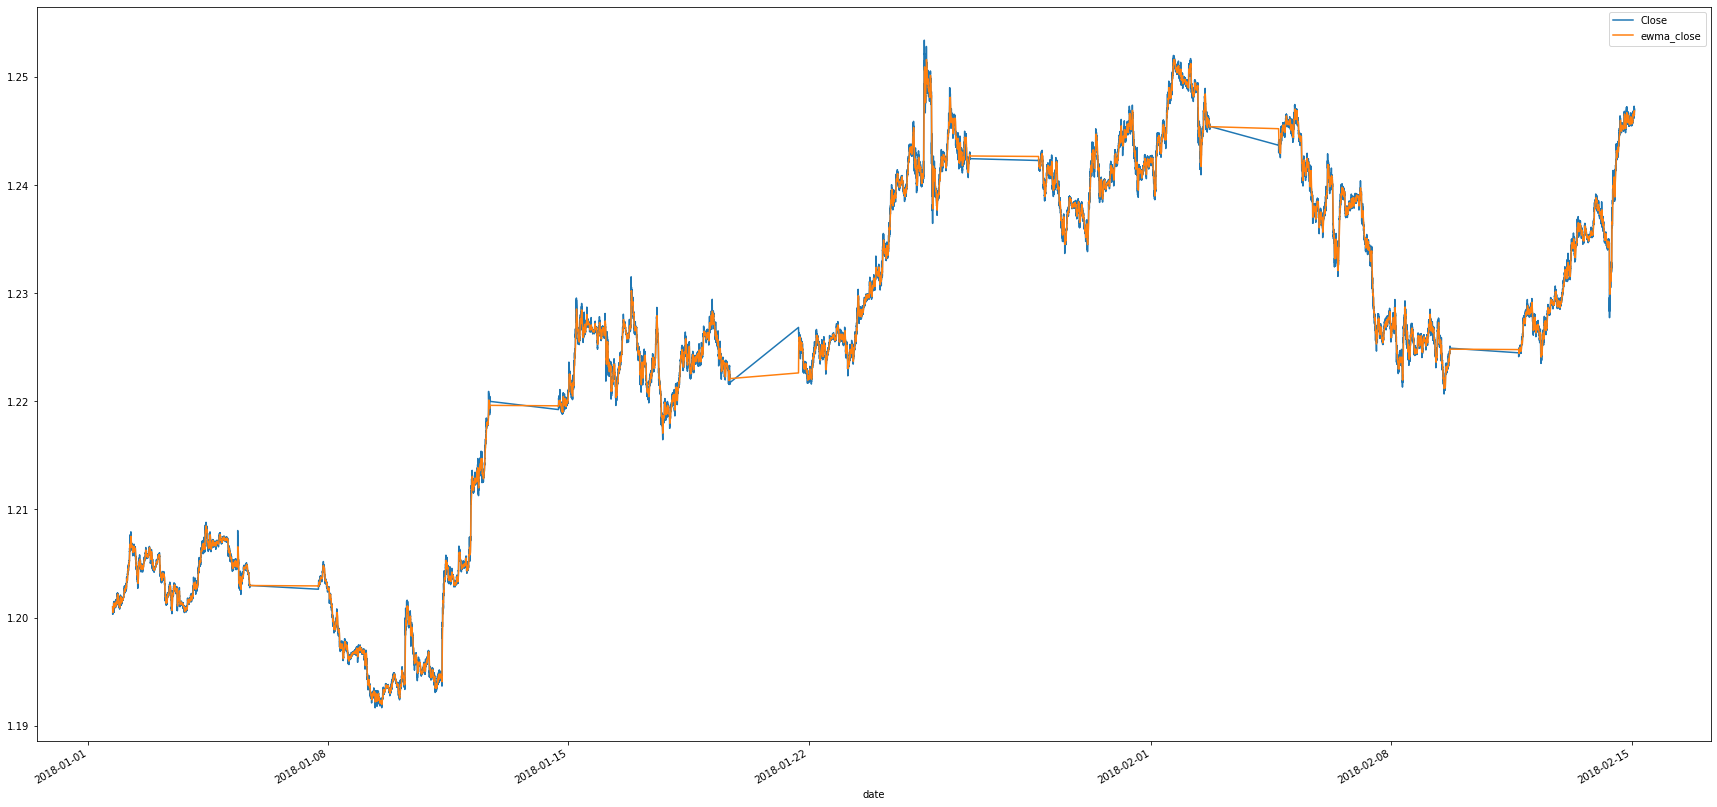

In [43]:
df["ewma_close"]=df["Close"].ewm(ewm).mean()
df.plot(figsize=(30,15))

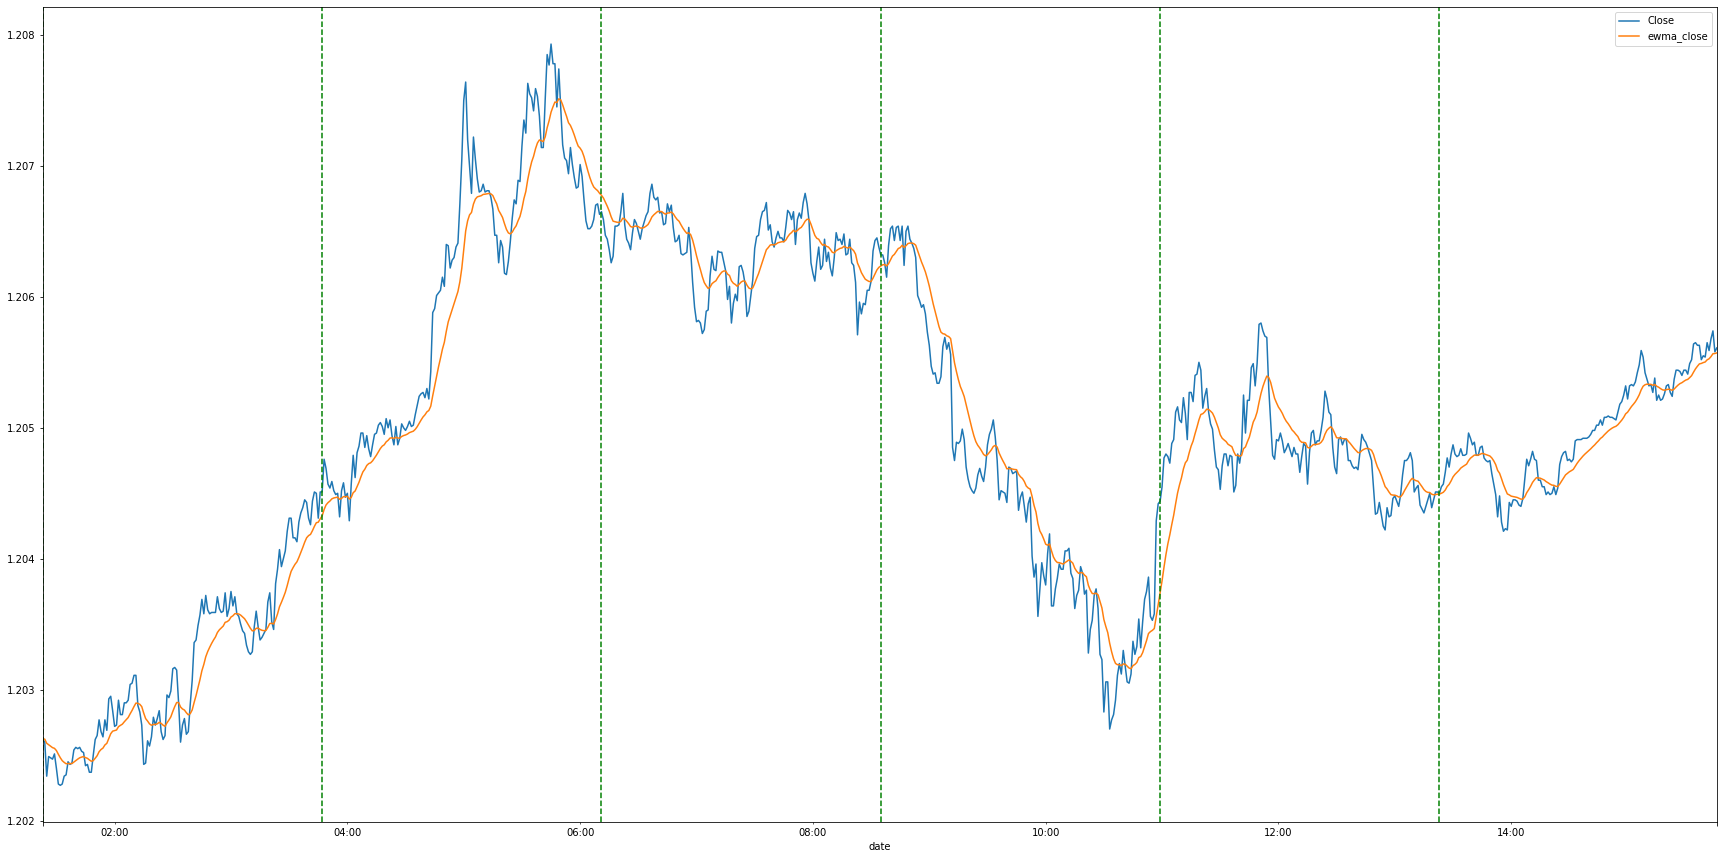

In [44]:
offset=500
period_num=6
ax=df[offset:offset+period_num*look_back].plot(figsize=(30,15))
for i in range(period_num):
    ax.axvline(df.index[offset+i*look_back], color="green", linestyle="--")

In [45]:
close_data = df['ewma_close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df.index[:split]
date_test = df.index[split:]

print(len(close_train))
print(len(close_test))

37260
9315


In [46]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

def getY(data):
    X_train = []
    y_train = []
    for i in range(look_back, len(data)-seq_len):
        X_train.append(data[i-look_back:i])
        y_train.append(data[i:i+seq_len])
    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

x_train,y_train=getY(close_train)
x_test, y_test=getY(close_test)

print(x_train.shape)
print(y_train.shape)

(37108, 144, 1)
(37108, 8, 1)


In [47]:

x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped).reshape(-1, look_back, 1)
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(-1, look_back, 1)

y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped).reshape(-1, seq_len, 1)
y_test_scaled = y_scaler.transform(y_test_reshaped).reshape(-1, seq_len, 1)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

validation_data = (x_test_scaled, y_test_scaled)

print(x_train_scaled.shape)               
print(y_train_scaled.shape)

Min: 0.0
Max: 1.0
(37108, 144, 1)
(37108, 8, 1)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=1e-7)

model = Sequential()

# model.add(Bidirectional(GRU(units=64, return_sequences=True),input_shape=(x_train_scaled.shape[1], 1)))
model.add(GRU(units=look_back,input_shape=(x_train_scaled.shape[1], 1)))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

# model.add(GRU(units=units))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

# model.add(GRU(units=16))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

# model.add(Dense(units=seq_len+10, activation="relu"))
# model.add(Dropout(0.15))
model.add(Dense(units=seq_len, activation="linear"))

optimizer = Adam(lr=1e-3)
model.compile(optimizer="adadelta", loss=loss)

In [49]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 144)               63504     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1160      
Total params: 64,664
Trainable params: 64,664
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
history=model.fit(x_train_scaled, y_train_scaled, epochs=num_epochs, validation_data=(x_test_scaled, y_test_scaled), batch_size=batch_size, shuffle=True, verbose=1, callbacks=[reduce_lr])

Epoch 1/7
145/145 [==============================] - 24s 164ms/step - loss: 0.3939 - val_loss: 0.4837 - lr: 0.0010
Epoch 2/7
145/145 [==============================] - 27s 186ms/step - loss: 0.3872 - val_loss: 0.4749 - lr: 0.0010
Epoch 3/7
145/145 [==============================] - 27s 189ms/step - loss: 0.3798 - val_loss: 0.4654 - lr: 0.0010
Epoch 4/7
145/145 [==============================] - 27s 186ms/step - loss: 0.3720 - val_loss: 0.4554 - lr: 0.0010
Epoch 5/7
145/145 [==============================] - 27s 184ms/step - loss: 0.3638 - val_loss: 0.4449 - lr: 0.0010
Epoch 6/7
145/145 [==============================] - 26s 181ms/step - loss: 0.3553 - val_loss: 0.4341 - lr: 0.0010
Epoch 7/7
145/145 [==============================] - 29s 198ms/step - loss: 0.3464 - val_loss: 0.4228 - lr: 0.0010


In [51]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

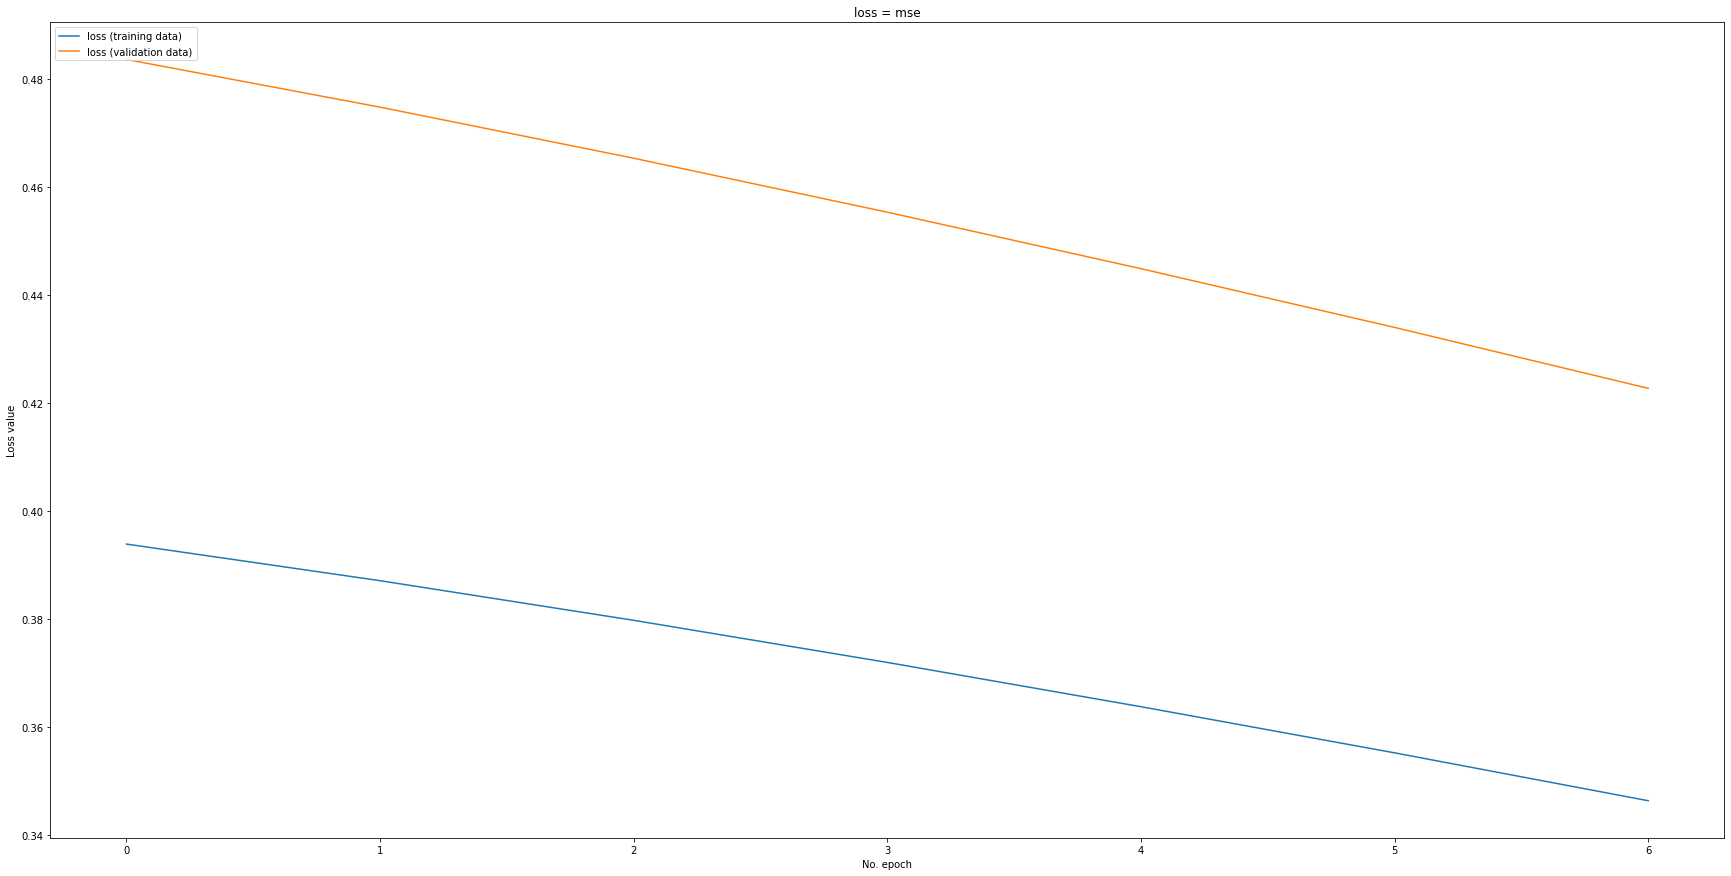

In [52]:
plotHistory(history)

In [53]:
def predictAndPlot(position=0, test=False, predictionPeriods=3):
    if test:
        x = x_test_scaled
    else:
        x = x_train_scaled

    prediction_list = np.array([x[position]])
    output=[]

    for i in range(predictionPeriods):
        y = model.predict(prediction_list).reshape(1,-1)[0]
        output.append(y)

        tmp = np.append(prediction_list[0].reshape(1,-1)[0],y)[-look_back:]
        predition_list = tmp.reshape(1, look_back, 1)

    pltx=x[position]
    pltx_unscaled = x_scaler.inverse_transform(pltx).reshape(1,-1)[0]
    
    plty=y_scaler.inverse_transform(np.array(output)).reshape(1,-1)[0]
    
    next_pltx = x_scaler.inverse_transform(x[position+len(pltx)]).reshape(1,-1)[0]

    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(pltx_unscaled, label='Base', color='orange')
    ax.plot([i for i in range(len(pltx), len(plty)+len(pltx))],plty, label='Predicted', color = 'blue')
    ax.plot([i for i in range(len(pltx), 2*len(pltx))], next_pltx, label='Next base', color = 'green')
#     ax.plot([i for i in range(0, 2*len(pltx))], df["Close"][position:][:2*len(pltx)],"g^", label='Original data', color = 'green')
    plt.xlabel('krok czasu')
    plt.ylabel('Stosunek euro/usd')
    # plt.savefig(f"pngs/cf{}")
    ax.legend()
    plt.show() 

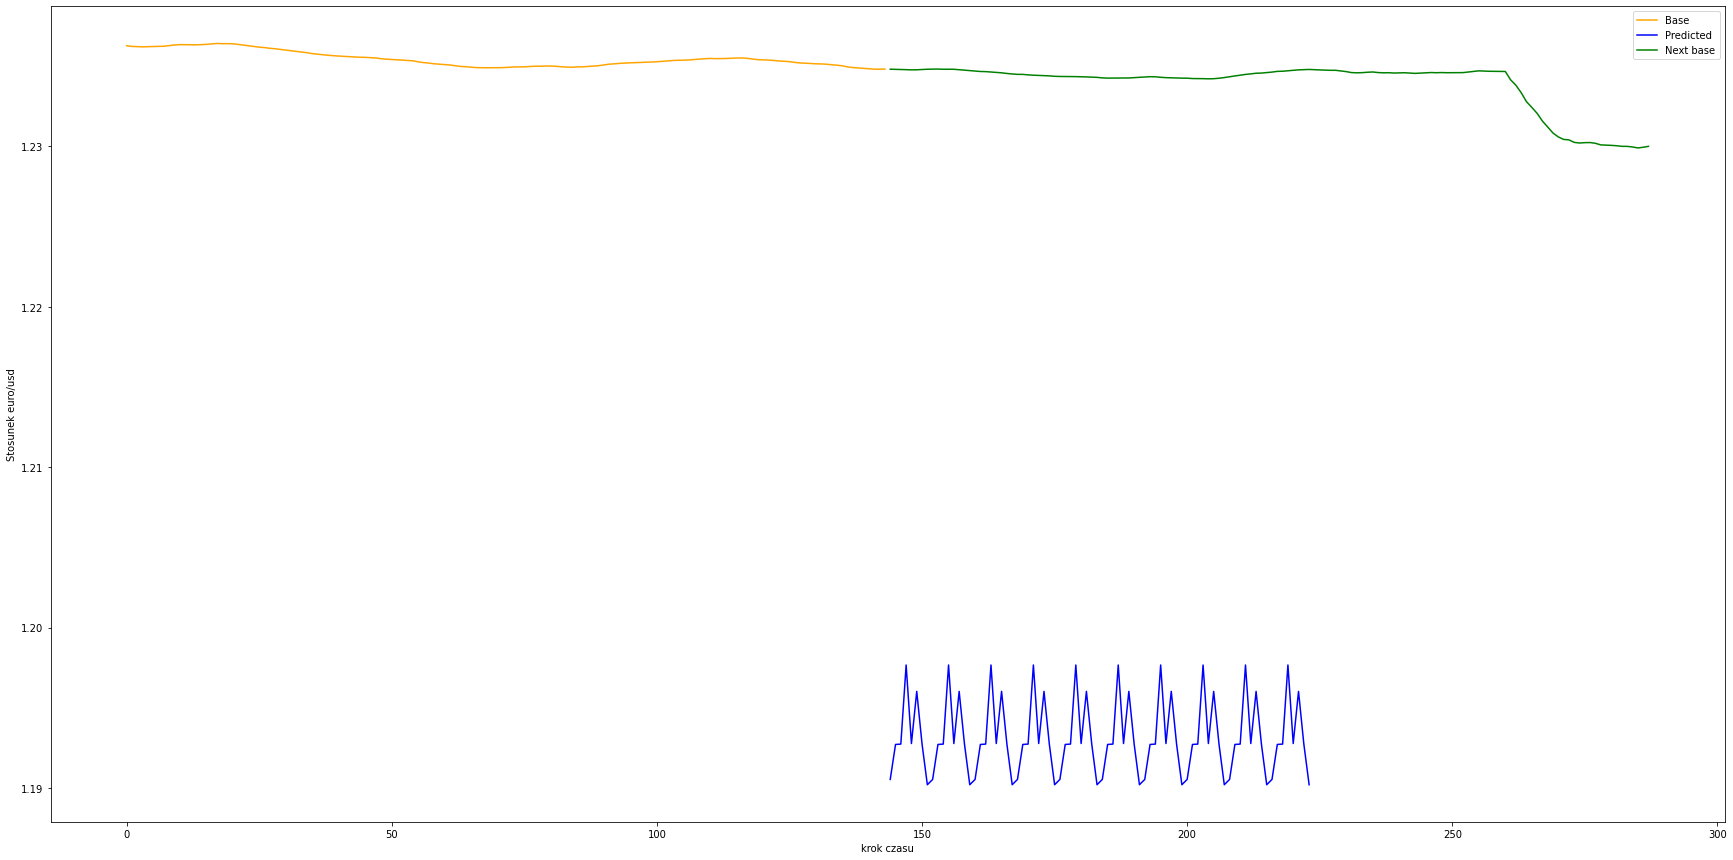

In [54]:
predictAndPlot(8000, True, 10)

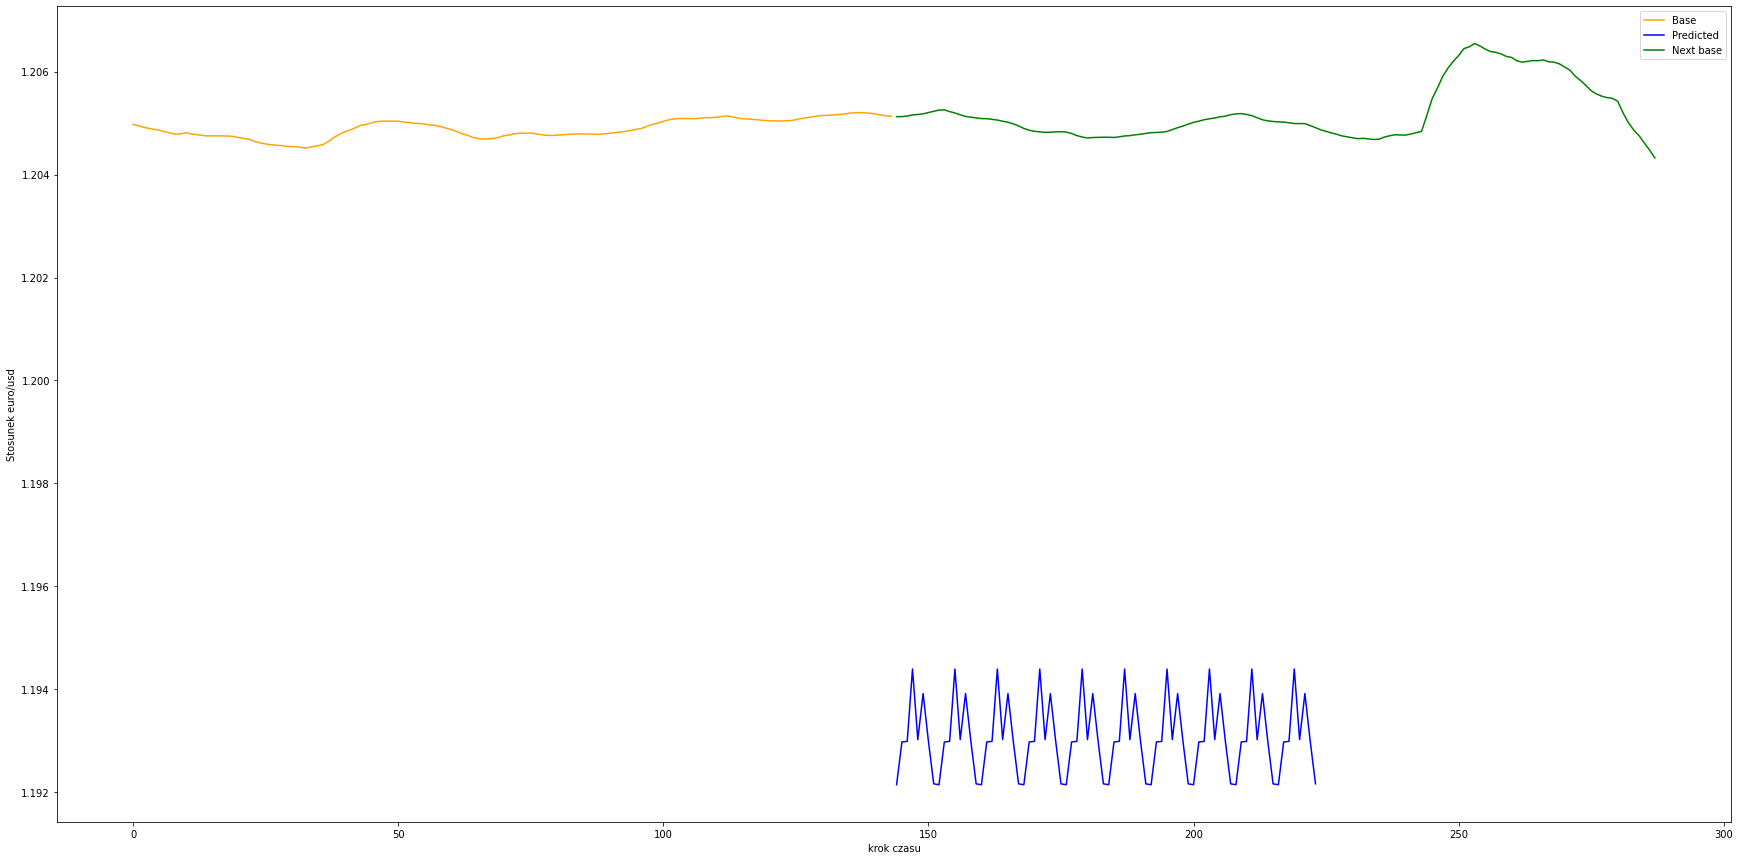

In [55]:
predictAndPlot(5000, False, 10)     

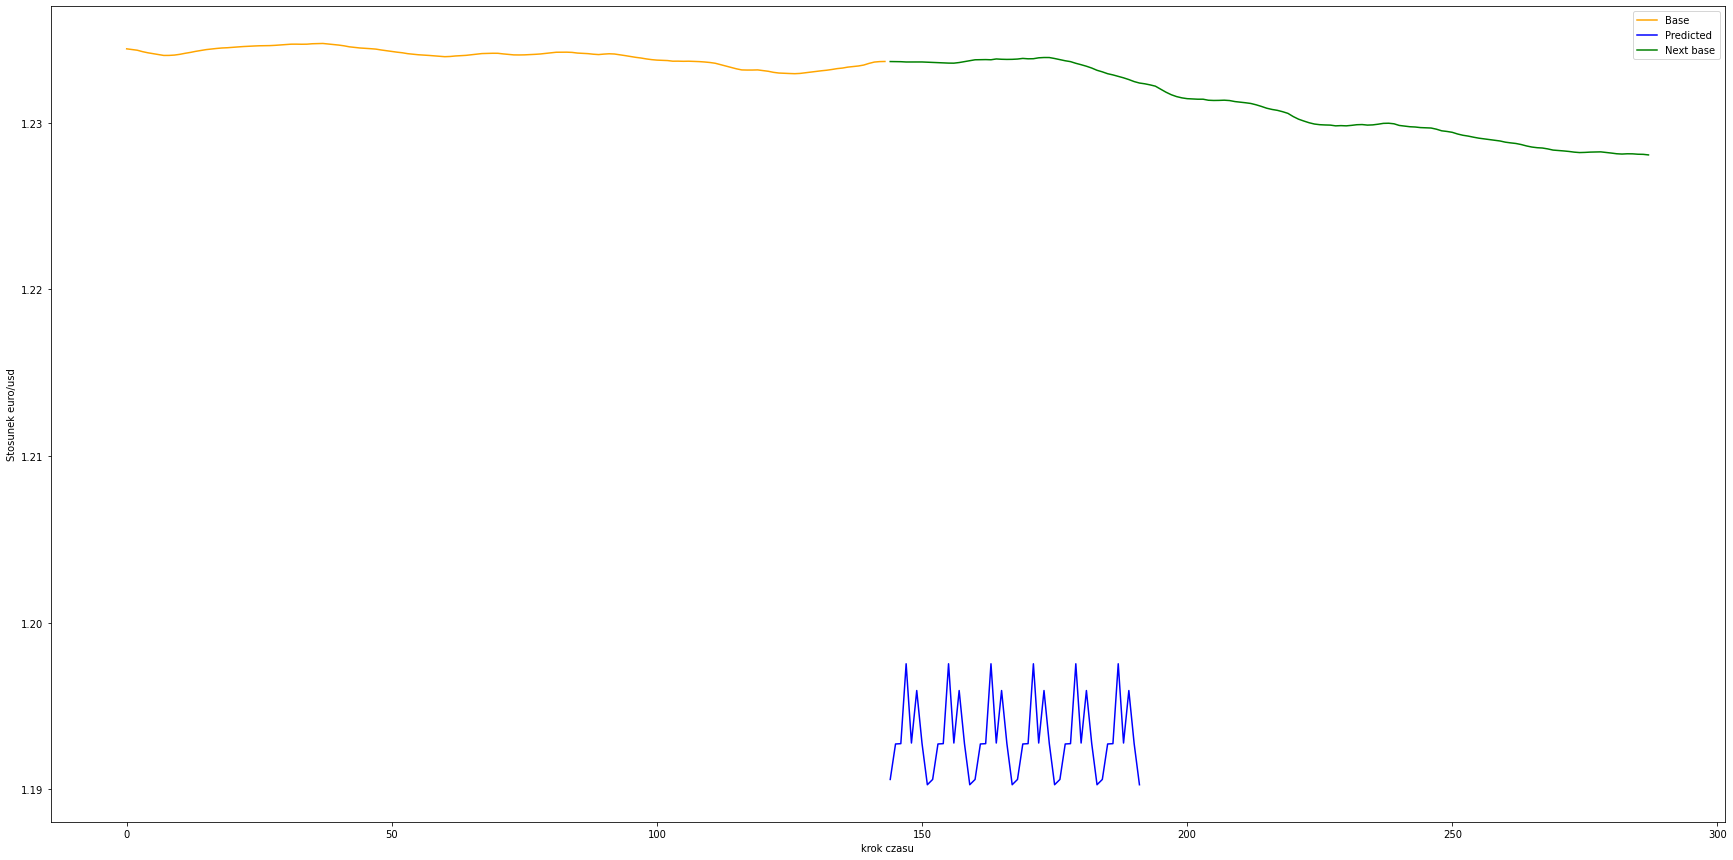

In [56]:
predictAndPlot(1000, True, 6)

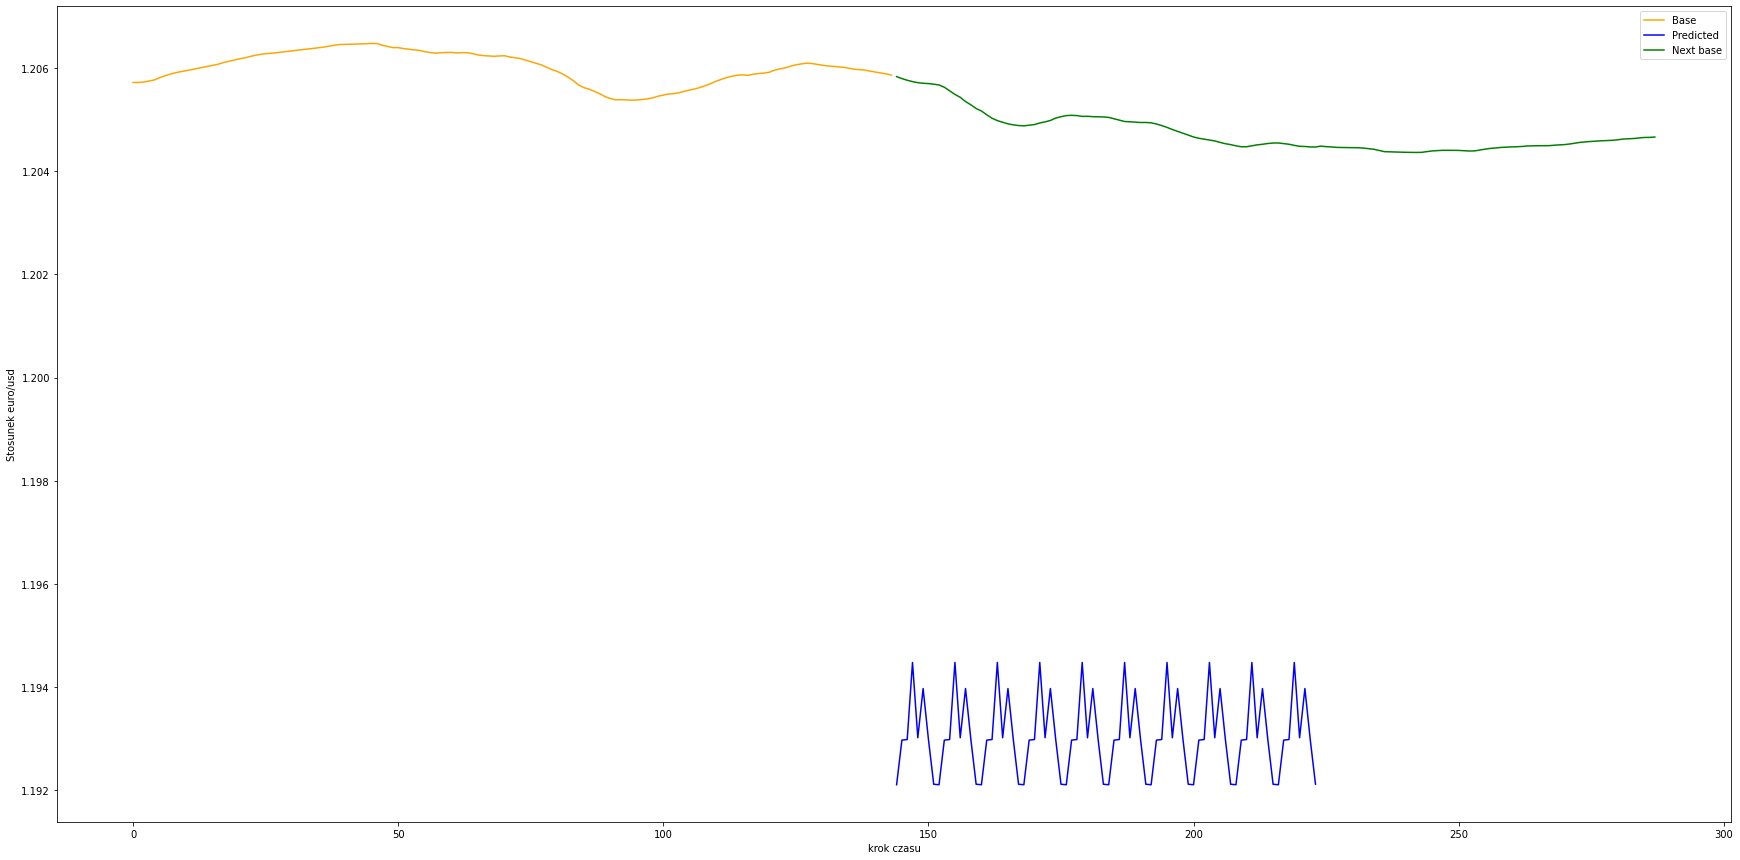

In [57]:
predictAndPlot(1500, False, 10)

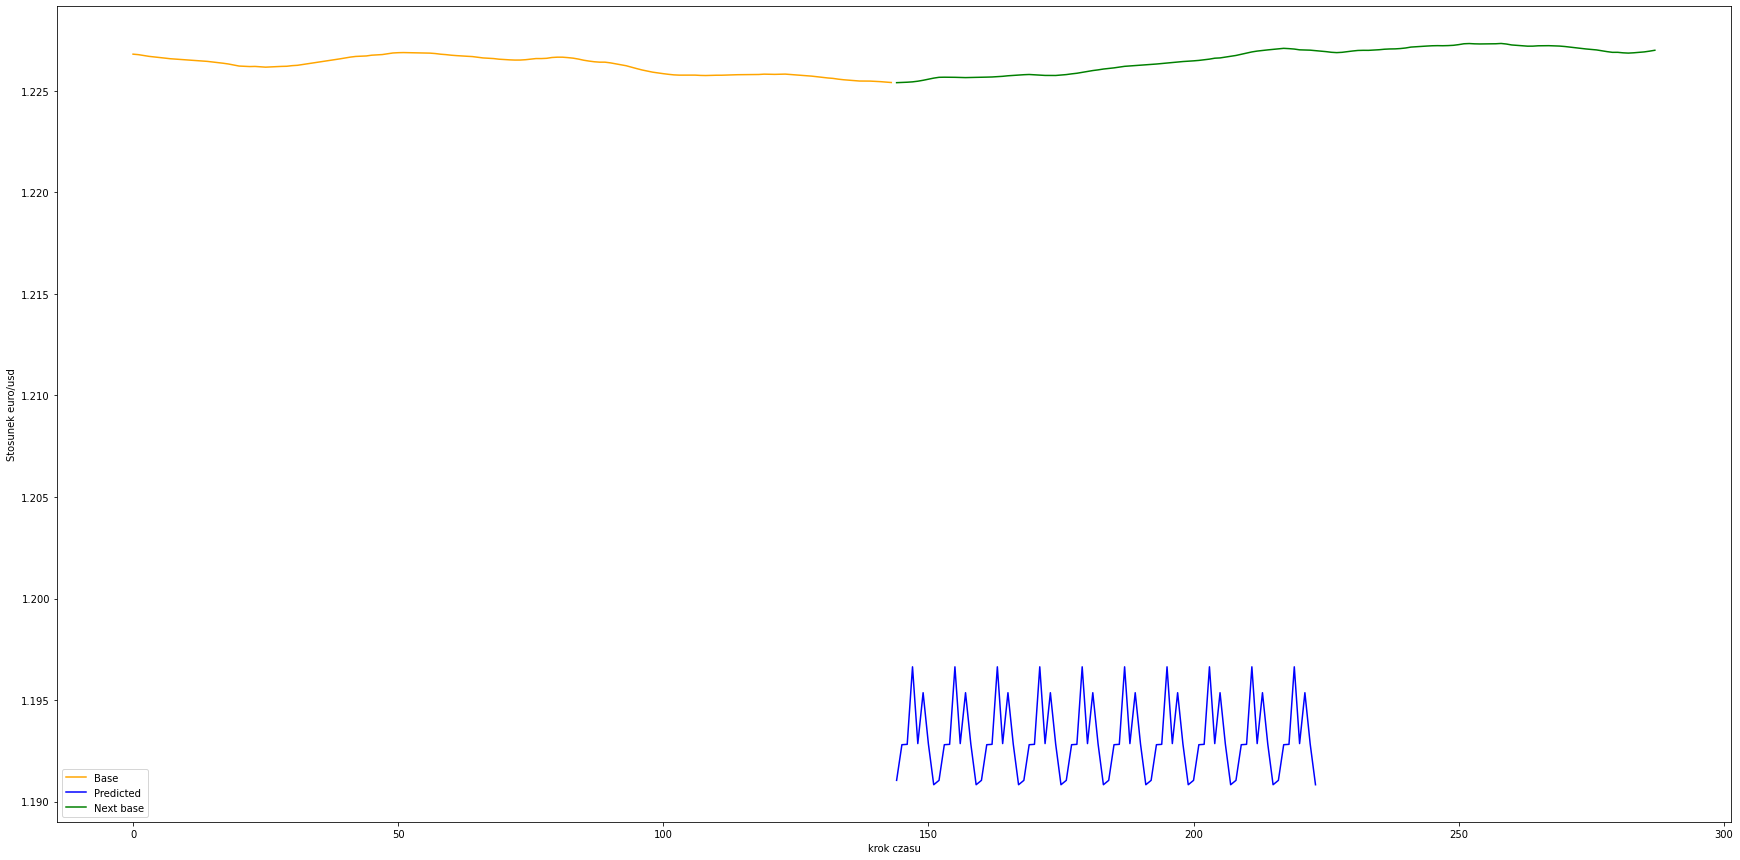

In [58]:
predictAndPlot(1500, True, 10)

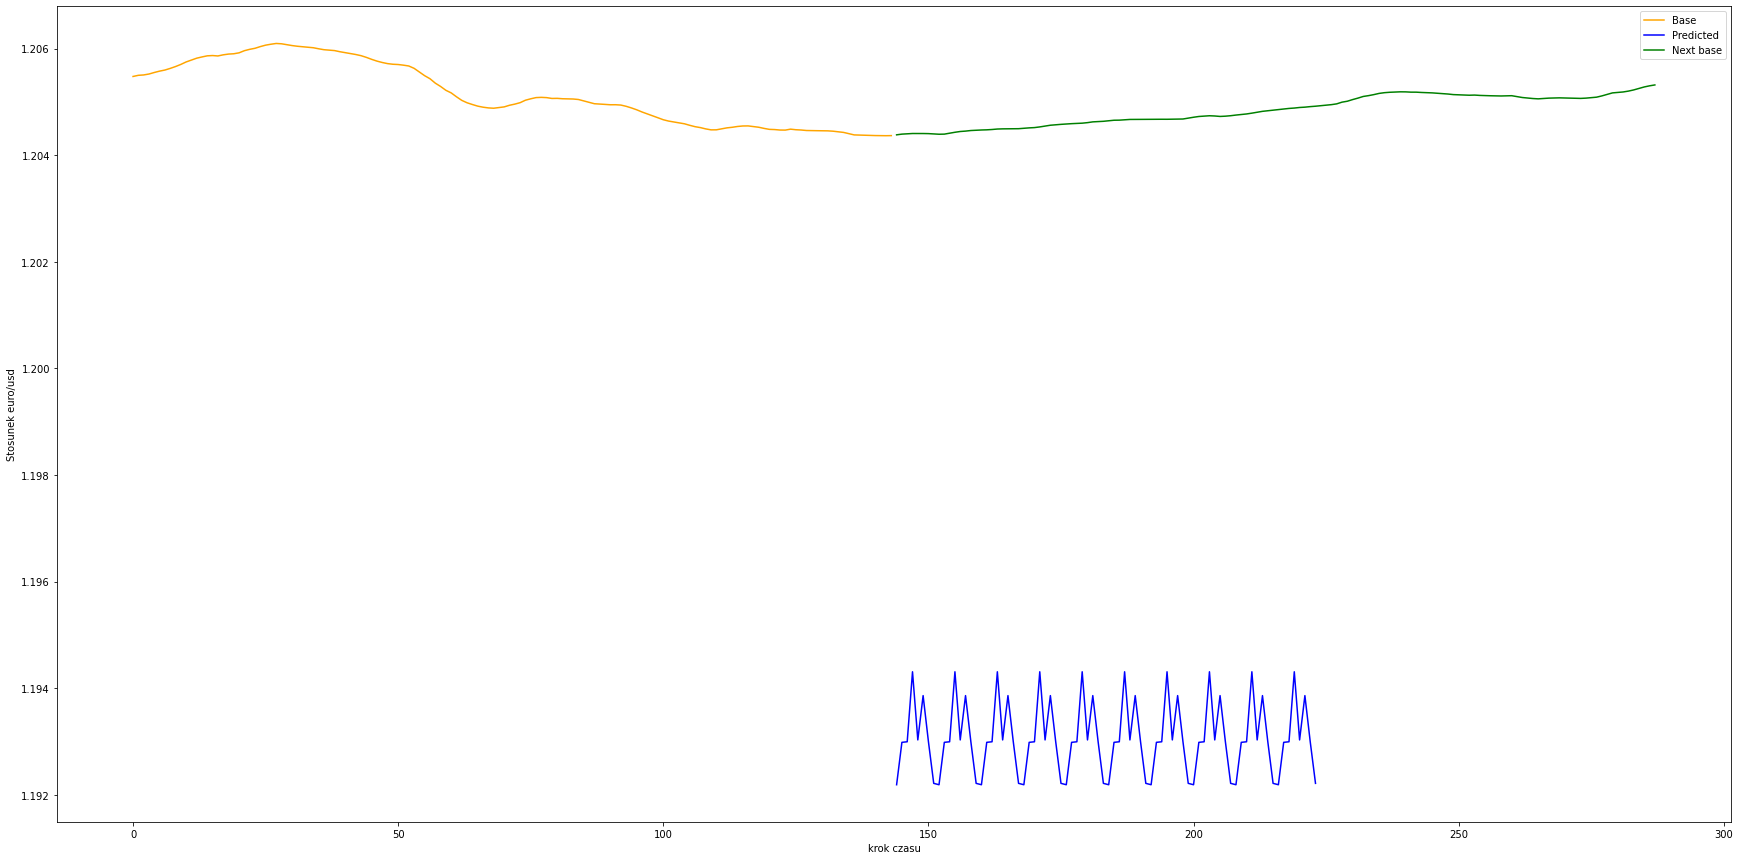

In [59]:
predictAndPlot(1600, False, 10)

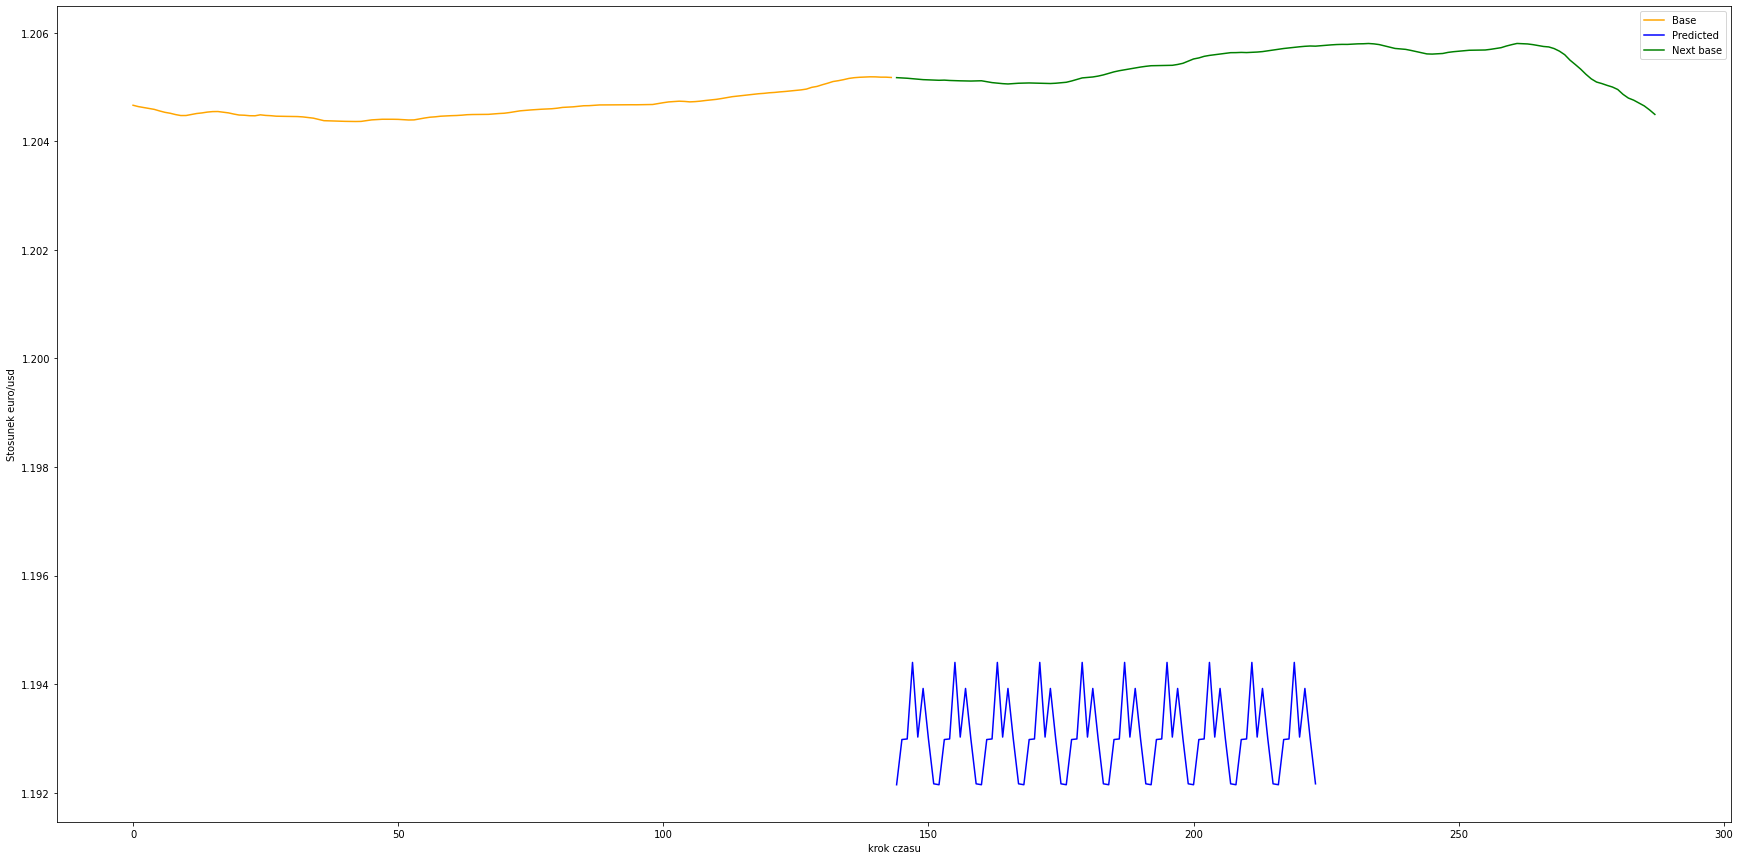

In [60]:
predictAndPlot(1700, False, 10)

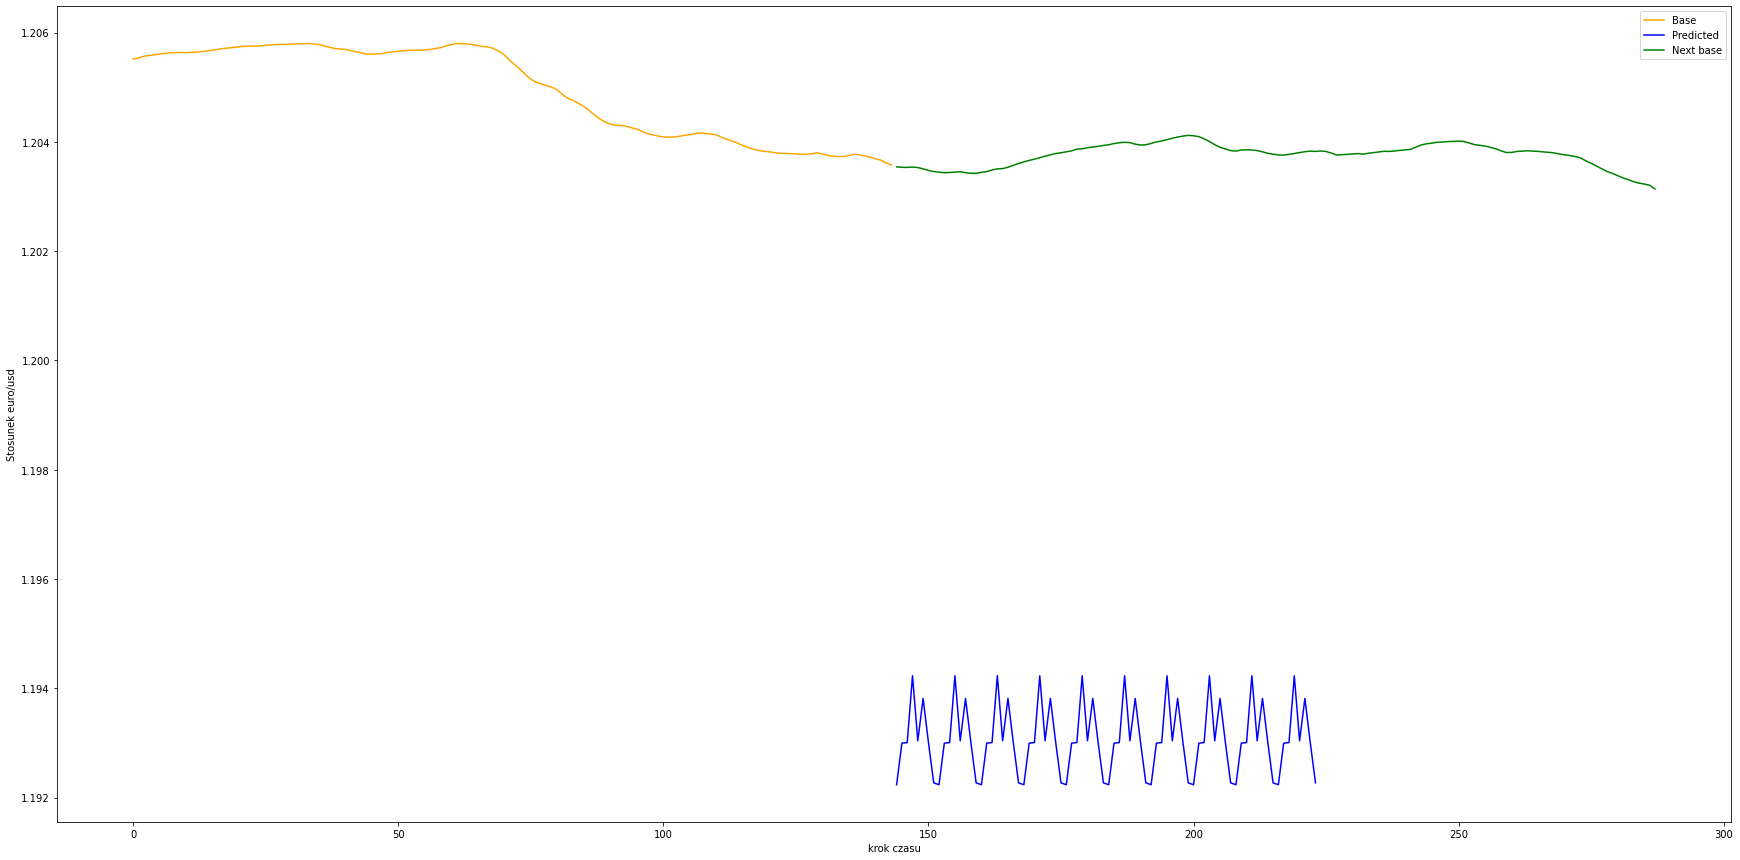

In [61]:
predictAndPlot(1900, False, 10)